In [118]:
import sys, os
modulepath = os.path.abspath("ssh_1d_cpp/build/bin-module/")
sys.path.insert(0,modulepath)

import ssh_1d
import numpy as np

N = 10
Ns = 2*N+1
psi0 = 0.01
t0=0.
t_end=1200
dt = 0.01

gamA = 0.16
# gamA = 0.48
gamB = gamA
gA = 0.44 + gamA
# gA = 0.06 + gamA
gB = 0
t1=1
t2=0.7

params = ssh_1d.TimeSeriesParams(N, psi0, gA, gB, gamA, gamB, t_end, dt, t1, t2)

time_series = ssh_1d.time_series(params)
t_values = time_series[:,0].real
psi_values = time_series[:,1:]

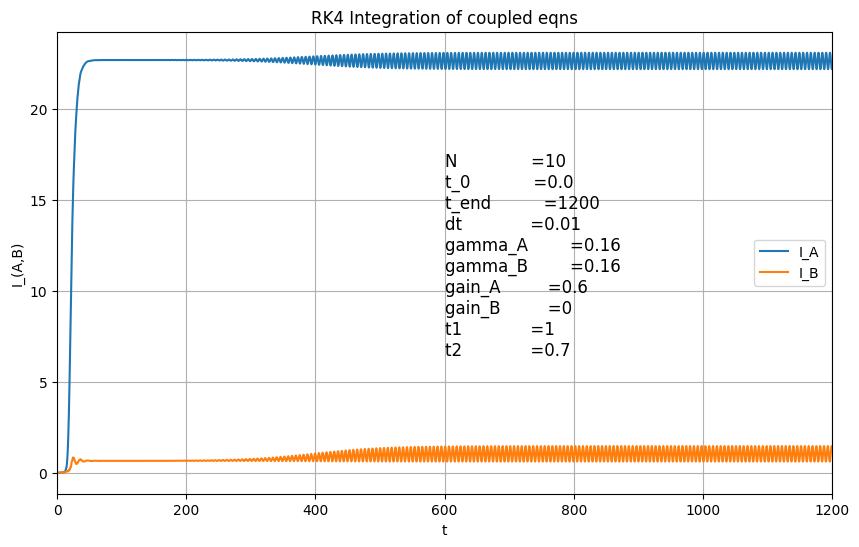

In [119]:
import matplotlib.pyplot as plt

t_values = time_series[:,0].real
psi_values = time_series[:,1:]

IA = np.sum(np.abs(psi_values[:,0::2])**2, axis=1)
IB = np.sum(np.abs(psi_values[:,1::2])**2, axis=1)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(t_values, IA, label='I_A')
ax.plot(t_values, IB, label='I_B')

ax.set_xlabel('t')
ax.set_ylabel('I_(A,B)')
ax.legend()
ax.set_title('RK4 Integration of coupled eqns')
# ax.set_xlim((400,600))
# ax.set_ylim((30.2499,30.2501))
ax.set_xmargin(0)
ax.grid(True)
params = {'N':N, 't_0':t0, 't_end': t_end, 'dt':dt, 'gamma_A':gamA, 'gamma_B':gamB, 'gain_A': gA, 'gain_B':gB, 't1':t1, 't2':t2}
paramtext = "\n".join([ f"{key:<15}={value:<6}" for key, value in params.items()])
ax.text(x=.5, y=.3,s=paramtext, color='black', transform=ax.transAxes, size=12)

plt.show()

In [120]:
#phase diagram as in fig 1b in paper
from numpy import fft
import concurrent.futures

def phase_diagram():
    numx = 50
    numy = 50

    x_ = np.linspace(0,.5,numx) # gamma_AB
    y_ = np.linspace(0,0.5,numy) # g_A - gamma_AB

    def oscillating_factor_worker(x,y):
        gamA = x
        params = ssh_1d.TimeSeriesParams(N=10, psi0=0.01, satGainA=y+gamA, satGainB=0.,
                                        gammaA=gamA, gammaB=gamA, time_end=1200, time_delta=0.01,
                                        t1=1., t2=0.7)
        time_series = ssh_1d.time_series(params)
        t_values = time_series[:,0].real
        psi_values = time_series[:,1:]

        time_filter = (850<t_values)*(t_values<900)
        psi_fft = fft.fft(psi_values[time_filter,:], axis=0)
        psi_fft_all_sites = np.sum(np.abs(psi_fft)**2, axis=1)
        return np.max(psi_fft_all_sites[1:])

    xy_pairs = np.array([(x,y) for y in y_ for x in x_])
    oscillating_factors = []

    with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
        futures = [executor.submit(oscillating_factor_worker, *(xy_pair)) for xy_pair in xy_pairs]
        oscillating_factors = [future.result() for future in futures]

    fig, ax = plt.subplots(figsize=(5, 5))

    x = xy_pairs[:,0]
    y = xy_pairs[:,1]
    ax.scatter(x,y, c=np.array(oscillating_factors)>8000, cmap='coolwarm')

    ax.set_xlabel('gamma_AB')
    ax.set_ylabel('g_A - gamma_AB')
    ax.set_title('phase diagram')
    ax.set_xmargin(0)
    ax.set_ymargin(0)
    ax.grid(True)

# phase_diagram()

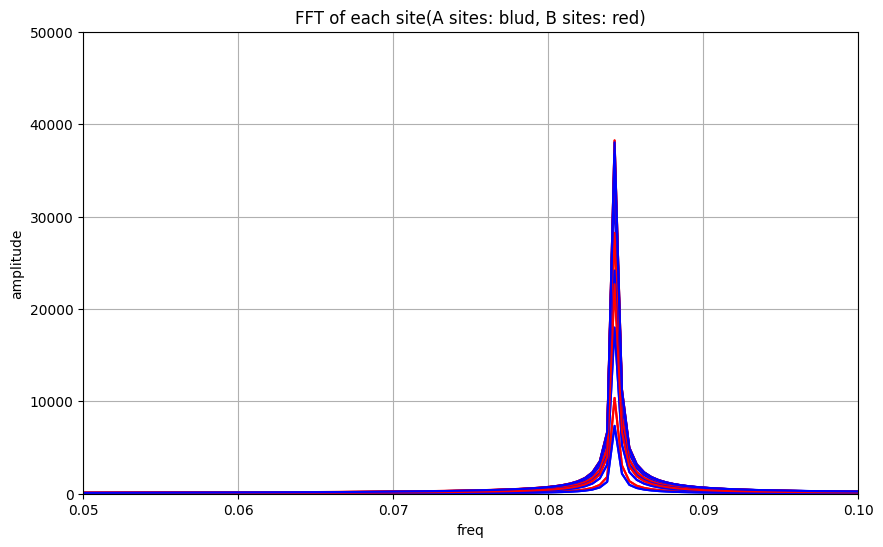

In [121]:
from numpy import fft
x = 0.16
y= .44
gamA = x
params = ssh_1d.TimeSeriesParams(N=10, psi0=0.01, satGainA=y+gamA, satGainB=0.,
                                     gammaA=gamA, gammaB=gamA, time_end=2500, time_delta=0.01,
                                     t1=1., t2=0.7)
time_series = ssh_1d.time_series(params)
t_values = time_series[:,0].real
psi_values = time_series[:,1:]



time_filter = (400<t_values)*(t_values<2500)
psi_fft = fft.fft(psi_values[time_filter,:], axis=0)
Nt = len(t_values[time_filter])
f_values = np.fft.fftfreq(Nt, d=0.01)
right_half_filter = f_values>=0


fig, ax = plt.subplots(figsize=(10, 6))

for site_index in range(Ns):
    color = 'b' if site_index%2==0 else 'r'
    ax.plot(f_values[right_half_filter], np.abs(psi_fft[right_half_filter,site_index]), c=color)

ax.set_xlabel('freq')
ax.set_ylabel('amplitude')
ax.set_title('FFT of each site(A sites: blud, B sites: red)')
ax.set_xlim((0.05,.1))
ax.set_ylim((0,5e4))
ax.set_xmargin(0)
ax.grid(True)
plt.show()

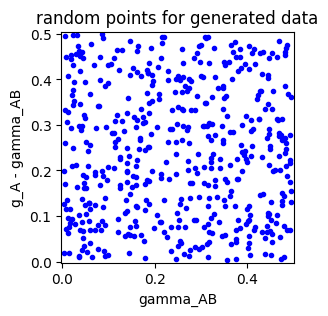

In [122]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42) #for reproducibility

num_time_series = 500

x_ = np.random.uniform(0, 0.5, num_time_series)
y_ = np.random.uniform(0, 0.5, num_time_series)

fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(x_, y_, color='blue', marker='.')
ax.set_xlabel('gamma_AB')
ax.set_ylabel('g_A - gamma_AB')
ax.set_title('random points for generated data')
ax.set_xmargin(0.01)
ax.set_ymargin(0.01)
plt.show()


In [123]:
#generate data
import concurrent.futures
import h5py

tsfilename = 'time_series.hdf5'
h5py.File(tsfilename, 'w').close() #must create empty existing file to avoid overloading python memory
time_sample_size = 1000

def time_series_worker(i, x,y):
    gamA = x
    params = ssh_1d.TimeSeriesParams(N=10, psi0=0.01, satGainA=y+gamA, satGainB=0.,
                                     gammaA=gamA, gammaB=gamA, time_end=1200, time_delta=0.01,
                                     t1=1., t2=0.7)
    time_series = ssh_1d.time_series(params)
    time_series = time_series[1799:,:] # start from 1800-th time step
    samp_indices = np.unique(np.round(np.linspace(0,time_series.shape[0]-1,time_sample_size))).astype(int)
    with h5py.File(tsfilename, 'a') as tsfile:
        data = time_series[samp_indices,:]
        dataset = tsfile.create_dataset(name=f'series_{i}', data = data)
        dataset.attrs['x'] = x
        dataset.attrs['y'] = y
        tsfile.flush()
    return 'success'

xy_pairs = np.array([(x,y) for x,y in zip(x_,y_)])


with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
    futures = [executor.submit(time_series_worker, i, *(xy_pair)) for i, xy_pair in enumerate(xy_pairs)]



In [124]:
import h5py
tsfilename = 'time_series.hdf5'

file = h5py.File(tsfilename, 'r')
x = []
for i in range(10):
    x.append( file[f'series_{i}'][:].real )
file.close()
x[0]

array([[ 1.79900000e+01,  2.09822893e-02, -1.51886652e-02, ...,
        -8.03250169e-02, -1.51886652e-02,  2.09822893e-02],
       [ 1.91700000e+01,  6.96489836e-02,  1.86330307e-02, ...,
        -7.14756209e-02,  1.86330307e-02,  6.96489836e-02],
       [ 2.03600000e+01,  1.13494687e-01,  1.06488827e-02, ...,
        -1.25291115e-01,  1.06488827e-02,  1.13494687e-01],
       ...,
       [ 1.19763000e+03,  4.57090322e-01,  3.03014802e-04, ...,
        -6.21634025e-01,  3.03014802e-04,  4.57090322e-01],
       [ 1.19882000e+03,  4.57090322e-01,  3.03014806e-04, ...,
        -6.21634025e-01,  3.03014806e-04,  4.57090322e-01],
       [ 1.20000000e+03,  4.57090322e-01,  3.03014848e-04, ...,
        -6.21634025e-01,  3.03014848e-04,  4.57090322e-01]])

(21, 21) (21,) (21, 1001)


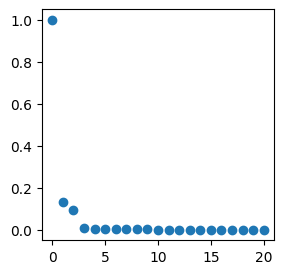

In [125]:
# svd: POD (supp. mat. sec A)
# https://static-content.springer.com/esm/art%3A10.1038%2Fs42005-023-01230-z/MediaObjects/42005_2023_1230_MOESM2_ESM.pdf
import ssh_1d
from numpy import linalg
import matplotlib.pyplot as plt

x = 0.16
y= .44
gamA = x
params = ssh_1d.TimeSeriesParams(N=10, psi0=0.01, satGainA=y+gamA, satGainB=0.,
                                     gammaA=gamA, gammaB=gamA, time_end=1200, time_delta=0.01,
                                     t1=1., t2=0.7)
time_series = ssh_1d.time_series(params)
t_values = time_series[:,0].real.T
psi_values = time_series[:,1:].T

time_sample_size = 1000
sample_step_size = len(t_values)//1000

t_values_samp = t_values[::sample_step_size]
psi_values_samp = psi_values[:,::sample_step_size]

Ns,Nt = psi_values_samp.shape
N0 = np.min([Nt,Ns])

U, S, Vh = linalg.svd(psi_values_samp, full_matrices=False)


fig, ax = plt.subplots(figsize=(3, 3))

ax.scatter(range(len(S)),S/S[0], label='sigma_i/sigma_1')
print(U.shape, S.shape, Vh.shape)

In [126]:
x = np.arange(50)
N = len(x)
P= 49
inds = np.unique(np.round(np.linspace(0,N-1,P))).astype(int)
print(x)
print(inds)
print(len(x[inds]))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49]
49


In [127]:
# https://bitbucket.org/topologicalphotonics/pti_dynamic_model/src/master/src/run_ssh_sat_gain.cpp
